In [1]:
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, LSTM, Dense, Dropout, 
                                     TimeDistributed, Flatten, BatchNormalization, 
                                     ELU, Reshape)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tensorflow.keras.layers import Bidirectional

# 1. Hyperparameters
SAMPLE_RATE = 16000
MAX_DURATION = 8  # seconds
MAX_LEN = SAMPLE_RATE * MAX_DURATION
N_MELS = 128
HOP_LENGTH = 512
N_FFT = 2048

# 2. Load CSV
csv_path = r"D:\Kyutech\Kaori Lab\08 Amil Experiment\experiment 05\Code\augmented_wav_dataset.csv"
df = pd.read_csv(csv_path)

# 3. Preprocessing Function
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    if len(y) > MAX_LEN:
        y = y[:MAX_LEN]
    else:
        y = np.pad(y, (0, MAX_LEN - len(y)))
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
    log_mel = librosa.power_to_db(mel_spec)
    return log_mel.T  # shape: (time, mel_bins)

# 4. Load All Data
X, y = [], []
for _, row in df.iterrows():
    try:
        features = preprocess_audio(row['file_path'])
        X.append(features)
        y.append(row['label'])
    except Exception as e:
        print(f"Error processing {row['file_path']}: {e}")

# 5. Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# 6. Final Shapes
X = np.array(X)
X = X[..., np.newaxis]  # (samples, time, mel, 1)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y_cat, random_state=42)

# 8. Build 2D CNN-LSTM Model
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=X_train.shape[1:]),
    BatchNormalization(), ELU(), MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(), ELU(), MaxPooling2D((4, 4)),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), ELU(), MaxPooling2D((4, 4)),
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(), ELU(), MaxPooling2D((4, 4)),
    Reshape((-1, 128)),
    Bidirectional(LSTM(128)),
    Dropout(0.15),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 9. Train
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint('best_model1.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stop, checkpoint, reduce_lr])


Epoch 1/100
23/23 [==============================] - 10s 156ms/step - loss: 1.6720 - accuracy: 0.3347 - val_loss: 3.6693 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - 2s 84ms/step - loss: 1.2078 - accuracy: 0.5401 - val_loss: 4.0392 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - 2s 85ms/step - loss: 0.9218 - accuracy: 0.6231 - val_loss: 4.4890 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - 2s 88ms/step - loss: 0.7652 - accuracy: 0.7103 - val_loss: 1.6216 - val_accuracy: 0.4326 - lr: 0.0010
Epoch 5/100
23/23 [==============================] - 2s 84ms/step - loss: 0.6084 - accuracy: 0.7778 - val_loss: 1.9921 - val_accuracy: 0.2809 - lr: 0.0010
Epoch 6/100
23/23 [==============================] - 2s 84ms/step - loss: 0.5628 - accuracy: 0.7778 - val_loss: 1.6958 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 7/100
23/23 [==============================] - 2s 88ms/step - 

6/6 [==============================] - 1s 22ms/step


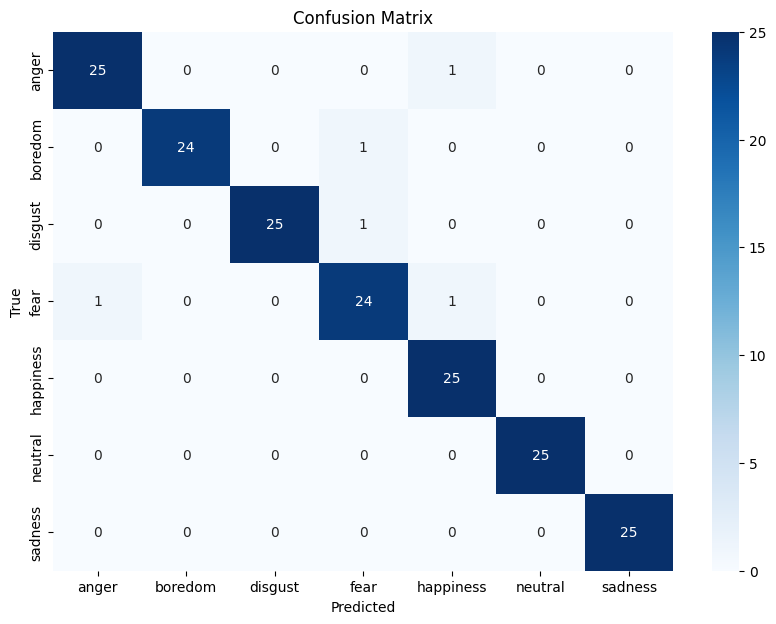


Classification Report:
              precision    recall  f1-score   support

       anger       0.96      0.96      0.96        26
     boredom       1.00      0.96      0.98        25
     disgust       1.00      0.96      0.98        26
        fear       0.92      0.92      0.92        26
   happiness       0.93      1.00      0.96        25
     neutral       1.00      1.00      1.00        25
     sadness       1.00      1.00      1.00        25

    accuracy                           0.97       178
   macro avg       0.97      0.97      0.97       178
weighted avg       0.97      0.97      0.97       178



In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Prediksi
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Nama label
labels = label_encoder.classes_

# 3. Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Visualisasi
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 5. Optional: Classification Report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels))


6/6 [==============================] - 0s 27ms/step


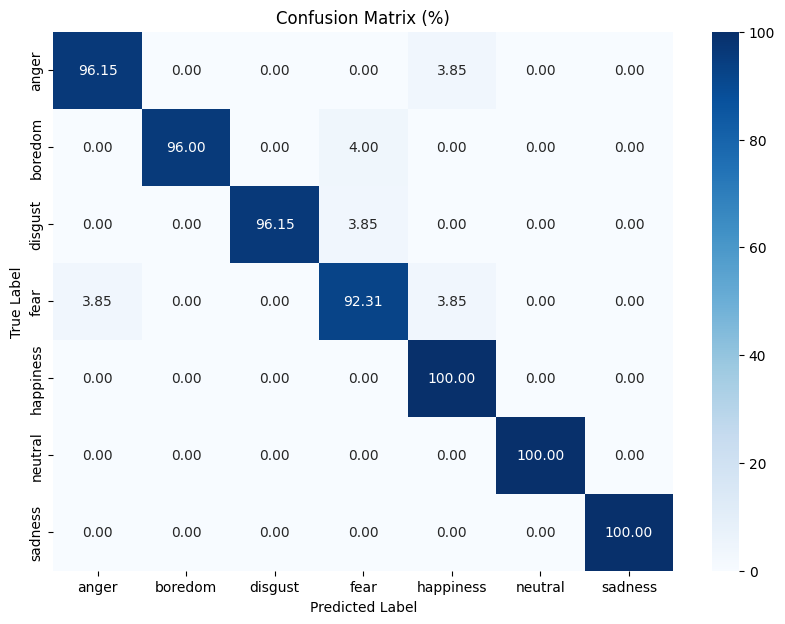

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Prediksi dan konversi ke kelas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Label kelas
labels = label_encoder.classes_

# 3. Hitung Confusion Matrix mentah
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4. Normalisasi ke Persentase per baris (per kelas sebenarnya)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent = np.round(cm_percent, 2)  # bulatkan ke 2 desimal

# 5. Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percent, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (%)")
plt.show()


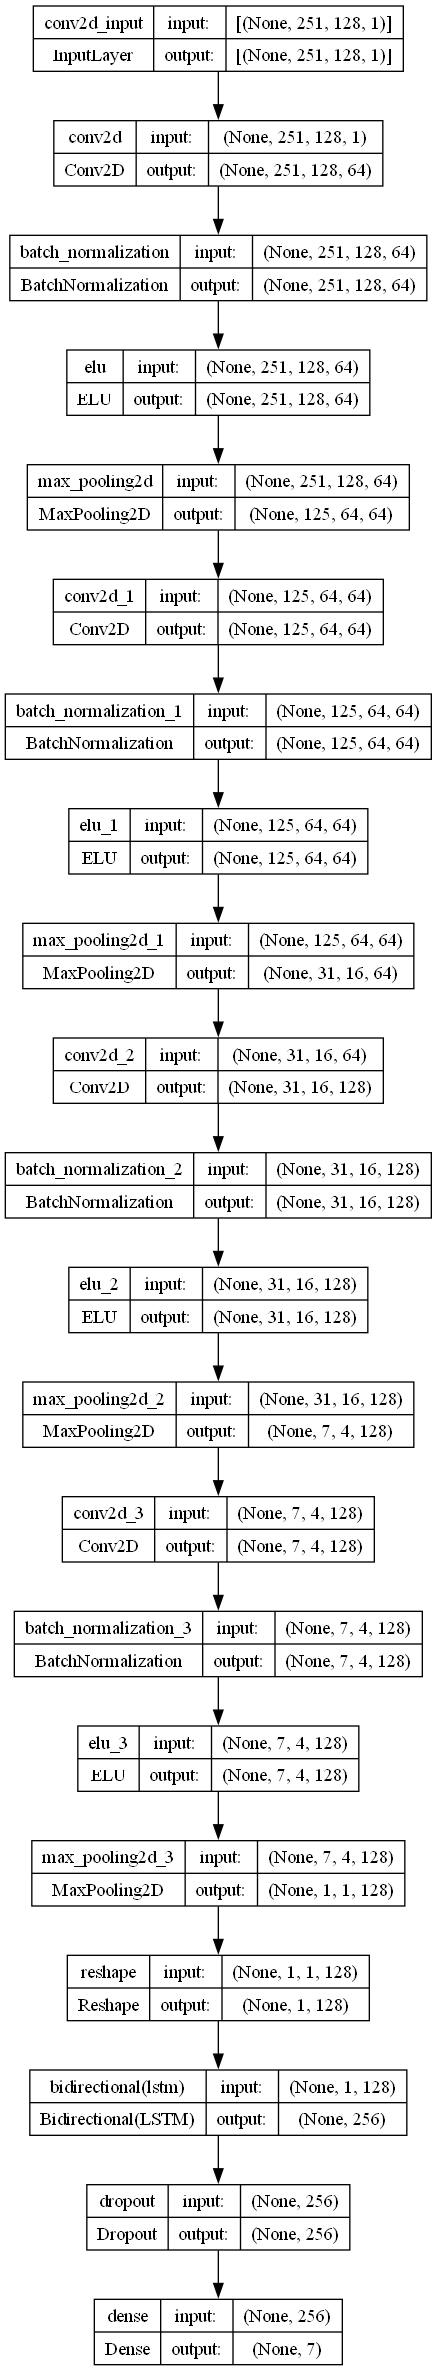

In [4]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='ensem_model.png', show_shapes=True, show_layer_names=True)

In [5]:
import pandas as pd

# 1. Prediksi kelas
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Konversi ke label string
predicted_labels = label_encoder.inverse_transform(y_pred_classes)
actual_labels = label_encoder.inverse_transform(y_true_classes)

# 3. Buat DataFrame
results_df = pd.DataFrame({
    'Predicted Labels': predicted_labels,
    'Actual Labels': actual_labels
})

# 4. Tampilkan 10 data pertama
print(results_df.head(10))

# 5. (Opsional) Simpan ke file CSV
results_df.to_csv("prediction_results.csv", index=False)


6/6 [==============================] - 0s 26ms/step
  Predicted Labels Actual Labels
0          neutral       neutral
1          disgust       disgust
2          disgust       disgust
3            anger         anger
4            anger         anger
5          sadness       sadness
6          sadness       sadness
7        happiness     happiness
8             fear          fear
9            anger         anger


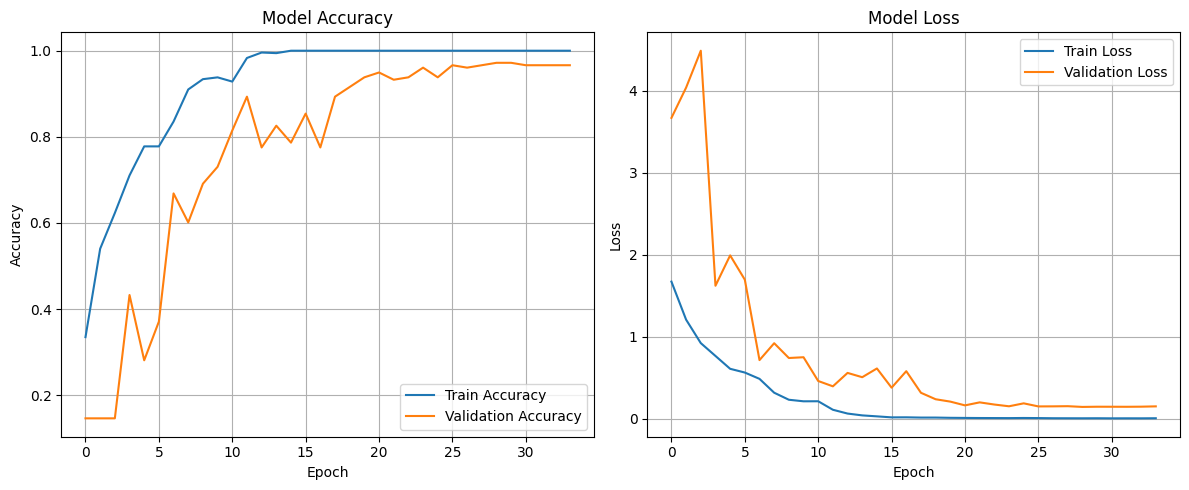

In [6]:
import matplotlib.pyplot as plt

# 1. Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Simpan model
model.save('model.h5')

# Simpan LabelEncoder
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
